# image controller

test list
2134
2198

In [1]:
box = (640,417,537,255)  


In [1]:
from my_tools.control import ImageController
controller = ImageController()

no function apply using default function


In [2]:
controller.run()

# model test


640-1280 is good
1449.jpg

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# # Load model directly
# from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

# processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-640-1280",return_tensors="pt")
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-640-1280")

## segformer hugging face

In [10]:
# custom preprocess
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

custom_process = transforms.Compose([

    transforms.ToTensor(),
    # transforms.Resize((512,1024)),
    transforms.Normalize(mean = mean,std= std)

])

img_mean = [123.675, 116.28, 103.53]
img_std = [58.395, 57.12, 57.375]

train_transform = transforms.Compose([
    transforms.Resize((1024, 512)),
    transforms.RandomResizedCrop((512, 1024), scale=(0.5, 2.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=img_mean, std=img_std)
])

# Testing data transformations
test_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((1024, 512)),
    transforms.Normalize(mean=img_mean, std=img_std)
])

In [11]:
from seg.seg_utils import HF_segFormermodel

# model_repo = "nvidia/segformer-b0-finetuned-cityscapes-768-768"
model_repo = "nvidia/segformer-b0-finetuned-cityscapes-512-1024"
# model_repo = "nvidia/segformer-b0-finetuned-cityscapes-640-1280"



seg_model = HF_segFormermodel(model_repo,custom_processor=custom_process)
# seg_model = HF_segFormermodel(model_repo)

using  cuda


In [7]:
seg_model.model.device

device(type='cuda', index=0)

In [8]:
seg_model.processor

SegformerImageProcessor {
  "_valid_processor_keys": [
    "images",
    "segmentation_maps",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "do_reduce_labels",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SegformerImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  }
}

In [14]:
def seg_wraper(img,crop_box):
    y1,y2, x1,x2 = crop_box
    img = img[y1:y2, x1:x2]
    preds, _ = seg_model.predict([img],upsampling=True)
    # raise Exception("hi")

    # segs = seg_model.get_seg_image(preds)
    
    # return segs

    overlays = seg_model.get_seg_overlay([img],preds) 
    return overlays

# controller.apply_processor(seg_wraper)
controller.process = seg_wraper

In [15]:
controller.run()

In [1]:
import cv2

img1 = cv2.imread("data/raw_4cams/front/3800.jpg")
img2 = cv2.imread("data/raw_4cams/left/1380.jpg")
img3 = cv2.imread("data/raw_4cams/right/1000.jpg")

In [12]:
img1.shape

(720, 1280, 3)

In [24]:
list_tensor = [test_transform(im) for im in [img1,img2,img3]]


In [25]:
batch_tensor = torch.stack(list_tensor, dim=0)

In [26]:
batch_tensor.shape

torch.Size([3, 3, 1024, 512])

In [32]:
batch_tensor = batch_tensor.to(device)

In [10]:
inputs = seg_model.processor([img1,img2,img3],return_tensors="pt")["pixel_values"].to(device)

In [10]:
inputs.shape

torch.Size([3, 3, 512, 512])

In [12]:
with torch.no_grad():

    logits = seg_model.model(pixel_values = inputs).logits

In [13]:
logits.shape

torch.Size([3, 19, 128, 128])

In [15]:
pred = logits.argmax(dim=1).cpu()
pred.shape

torch.Size([3, 128, 128])

In [21]:
img = cv2.resize(img1,(pred[0].shape[0],pred[0].shape[1]))

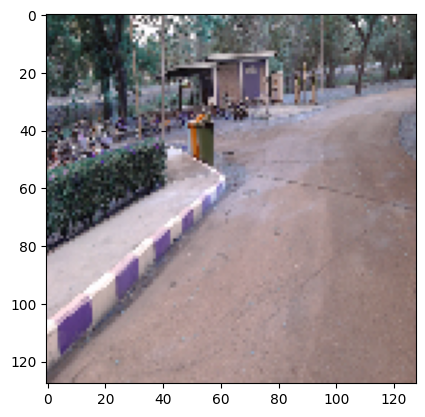

In [22]:
plt.imshow(img)

In [20]:
from torch import nn
upsampled_logits = nn.functional.interpolate(
    logits,
    size=img1.shape[:-1], # (height, width)
    mode='bilinear',
    align_corners=False
)

In [25]:
upsampled_logits.shape

torch.Size([3, 19, 720, 1280])

In [21]:
pred = upsampled_logits.argmax(dim=1).cpu()

In [23]:
pred[0].shape

torch.Size([720, 1280])

In [ ]:
def sidewalk_palette():
        """Sidewalk palette that maps each class to RGB values."""
        return [
            [155, 155, 155],
            [216, 82, 24],
            [255, 255, 0],
            [125, 46, 141],
            [118, 171, 47],
            [161, 19, 46],
            [255, 0, 0],
            [0, 128, 128],
            [190, 190, 0],
            [0, 255, 0],
            [0, 0, 255],
            [170, 0, 255],
            [84, 84, 0],
            [84, 170, 0],
            [84, 255, 0],
            [170, 84, 0],
            [170, 170, 0],
            [170, 255, 0],
            [255, 84, 0],
            [255, 170, 0],
            [255, 255, 0],
            [33, 138, 200],
            [0, 170, 127],
            [0, 255, 127],
            [84, 0, 127],
            [84, 84, 127],
            [84, 170, 127],
            [84, 255, 127],
            [170, 0, 127],
            [170, 84, 127],
            [170, 170, 127],
            [170, 255, 127],
            [255, 0, 127],
            [255, 84, 127],
            [255, 170, 127],
        ]

def get_seg_overlay(images, segs):
    imgs=[]
    for i in range(len(images)):
        color_seg = np.zeros((segs[i].shape[0], segs[i].shape[1], 3), dtype=np.uint8) # height, width, 3
        palette = np.array(sidewalk_palette())
        for label, color in enumerate(palette):
            color_seg[segs[i] == label, :] = color

        # Show image + mask
        img = np.array(images[i]) * 0.5 + color_seg * 0.5
        imgs.append(img.astype(np.uint8))

    return imgs

In [43]:
overlays = get_seg_overlay([img1,img2,img3],pred)

In [45]:
import cv2 
for i,overlay in enumerate(overlays):
    name = f"test{i}"
    cv2.imshow(name,overlay)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:
batch_tensor = np.stack([img1,img2,img3], axis=0)

In [16]:
batch_tensor.shape

(3, 720, 1280, 3)

In [ ]:
seg,overlay,logits = seg_model.predict(batch_tensor)

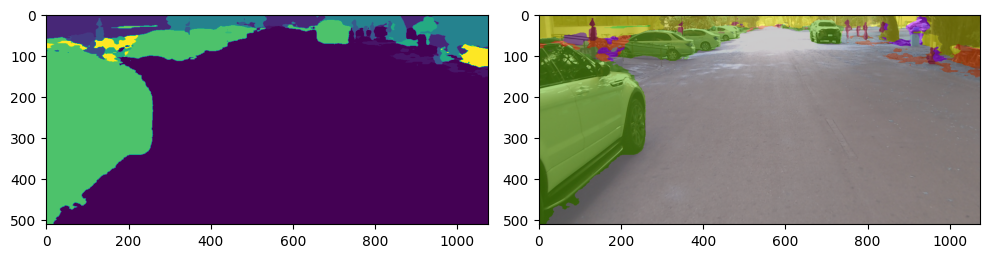

In [21]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(10, 30))
ax[0].imshow(pred)
ax[1].imshow(overlayed)

plt.tight_layout()  # Optional: Adjust subplot parameters to give specified padding
plt.show()


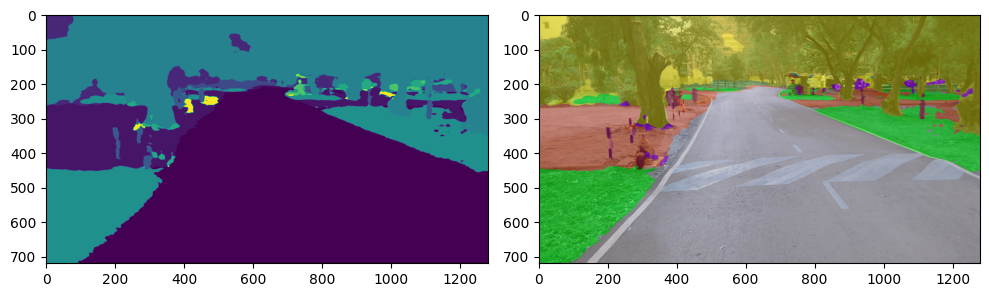

In [9]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(10, 30))
ax[0].imshow(pred)
ax[1].imshow(overlayed)

plt.tight_layout()  # Optional: Adjust subplot parameters to give specified padding
plt.show()


## mask2former hugging face

In [2]:
import requests
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

# Load Mask2Former model and image processor
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic")



/home/lpr/miniconda3/envs/CarlaEnv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import cv2

img1 = cv2.imread("data/raw_4cams/front/263.jpg")
img2 = cv2.imread("data/raw_4cams/left/1380.jpg")
img3 = cv2.imread("data/raw_4cams/right/1000.jpg")

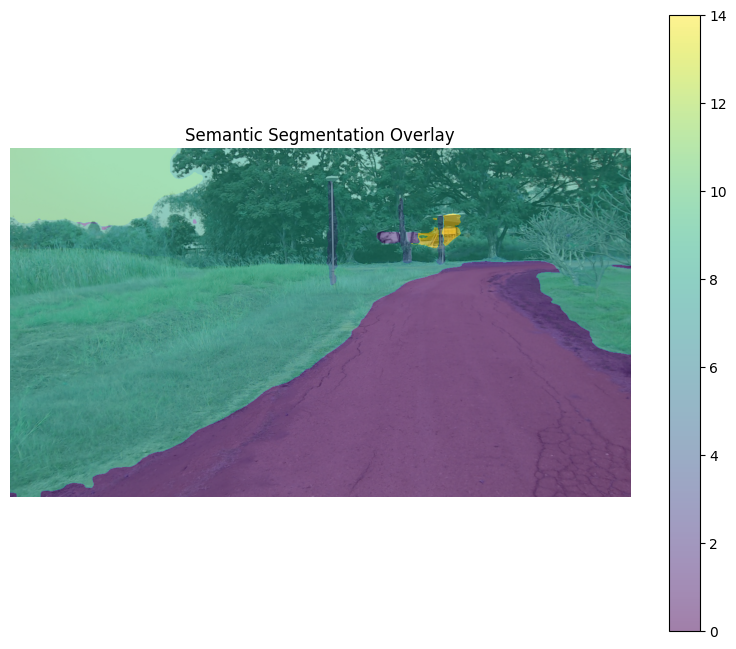

In [5]:
# Load an image from URL
images = [img1]

# Preprocess the image
inputs = processor(images=images, return_tensors="pt")

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Post-process to get predicted semantic map
predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[images[0].shape[:-1]])[0]

# Convert predicted semantic map to a numpy array
predicted_semantic_map_np = predicted_semantic_map.cpu().numpy()

# Visualize the original image with overlay of semantic segmentation
plt.figure(figsize=(10, 8))

# Plot the original image
plt.imshow(images[0])
plt.axis('off')

# Overlay the semantic segmentation on the original image
plt.imshow(predicted_semantic_map_np, alpha=0.5, cmap='viridis')  # Adjust alpha for transparency
plt.colorbar()  # Show colorbar for semantic classes

# Add a title
plt.title("Semantic Segmentation Overlay")

# Show the plot
plt.show()


In [3]:
import requests
import matplotlib.pyplot as plt
from transformers import pipeline
import torch

segmenter = pipeline(
    "image-segmentation",
    model="facebook/mask2former-swin-large-cityscapes-semantic",
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

In [9]:
from PIL import Image
pil_image = Image.fromarray(img1)
results = segmenter(pil_image)

`label_ids_to_fuse` unset. No instance will be fused.


In [10]:
results

[{'score': 0.948429,
  'label': 'sky',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': 0.933613,
  'label': 'building',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': 0.999472,
  'label': 'road',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': 0.999346,
  'label': 'pole',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': 0.999667,
  'label': 'terrain',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': 0.999889,
  'label': 'vegetation',
  'mask': <PIL.Image.Image image mode=L size=1280x720>}]

In [11]:
import numpy as np

masks = [result['mask'] for result in results]
# Convert PIL masks to numpy arrays
masks = [np.array(mask) for mask in masks]


In [13]:
color=sidewalk_palette()

In [24]:
color[0]

[155, 155, 155]

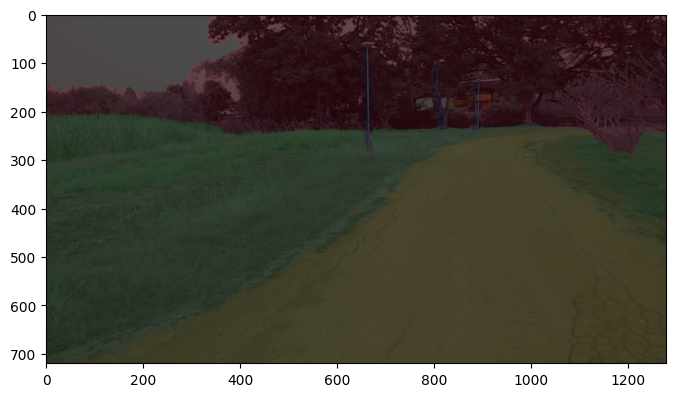

In [16]:
import matplotlib.pyplot as plt

# Display the original image
plt.figure(figsize=(8, 6))
plt.imshow(pil_image)

# Overlay each mask on the image
for i, result in enumerate(results):
    mask = masks[i]
    label = result['label']
    # Create a mask color for each class
    mask_color = np.zeros_like(pil_image)
    mask_color[mask == 255] = color[i] # Assuming RGB image

    # Display the mask overlay
    plt.imshow(mask_color, alpha=0.2)  # Adjust alpha for transparency

    # Show the class label as the plot title
    # plt.title(f"Class: {label}")
    # plt.axis('off')
plt.show()


## tao toolkit

In [3]:
import onnx
model_path = "seg/tao_model/pretrained_segformer_cityscapes_deployable_fan_tiny_hybrid_v1.0/cityscapes_fan_tiny_hybrid_224.onnx"
onnx_model = onnx.load(model_path)
onnx.checker.check_model(onnx_model)

ModuleNotFoundError: No module named 'onnx'

In [1]:
import onnxruntime as ort
import numpy as np
model_path = "seg/tao_model/pretrained_segformer_cityscapes_deployable_fan_tiny_hybrid_v1.0/cityscapes_fan_tiny_hybrid_224.onnx"
ort_sess = ort.InferenceSession(model_path, providers=['TensorrtExecutionProvider', 'CUDAExecutionProvider'])


*************** EP Error ***************
EP Error /onnxruntime_src/onnxruntime/python/onnxruntime_pybind_state.cc:456 void onnxruntime::python::RegisterTensorRTPluginsAsCustomOps(onnxruntime::python::PySessionOptions&, const ProviderOptions&) Please install TensorRT libraries as mentioned in the GPU requirements page, make sure they're in the PATH or LD_LIBRARY_PATH, and that your GPU is supported.
 when using ['TensorrtExecutionProvider', 'CUDAExecutionProvider']
Falling back to ['CUDAExecutionProvider', 'CPUExecutionProvider'] and retrying.
****************************************


2024-04-24 21:15:11.666968394 [E:onnxruntime:Default, provider_bridge_ort.cc:1534 TryGetProviderInfo_TensorRT] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1209 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_tensorrt.so with error: libcudnn.so.8: cannot open shared object file: No such file or directory

2024-04-24 21:15:11.704622668 [E:onnxruntime:Default, provider_bridge_ort.cc:1548 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1209 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcudnn.so.8: cannot open shared object file: No such file or directory

2024-04-24 21:15:11.704634992 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:861 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please refere

In [3]:
import tensorrt

# Check TensorRT version
print("TensorRT version:", tensorrt.__version__)
assert tensorrt.Builder(tensorrt.Logger())

TensorRT version: 10.0.0b6
[04/24/2024-21:25:07] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading


In [44]:
ort_sess.get_device() 

AttributeError: 'InferenceSession' object has no attribute 'get_device'

In [21]:
import cv2

img1 = cv2.imread("data/raw_4cams/front/263.jpg")
img2 = cv2.imread("data/raw_4cams/left/1380.jpg")
img3 = cv2.imread("data/raw_4cams/right/1000.jpg")

In [ ]:
input_size = (224, 224)
img1 = cv2.resize(img1, input_size)
img2 = cv2.resize(img2, input_size)
img3 = cv2.resize(img3, input_size)

In [26]:
batch_imgs = np.stack([img1,img2,img3], axis=0)
batch_imgs.shape

(3, 720, 1280, 3)

In [27]:
inputs = torch.tensor(batch_imgs)
inputs.shape

torch.Size([3, 720, 1280, 3])

In [34]:
img1.shape

(224, 224, 3)

In [36]:
trans_img1 = np.transpose(img1,(2,0,1))
trans_img1.shape

(3, 224, 224)

In [37]:
outputs = ort_sess.run(None, {'input': [trans_img1]})

In [53]:
outputs

[array([[[[4, 4, 4, ..., 8, 8, 8],
          [4, 4, 4, ..., 8, 8, 8],
          [4, 4, 4, ..., 8, 8, 8],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]]], dtype=int64)]

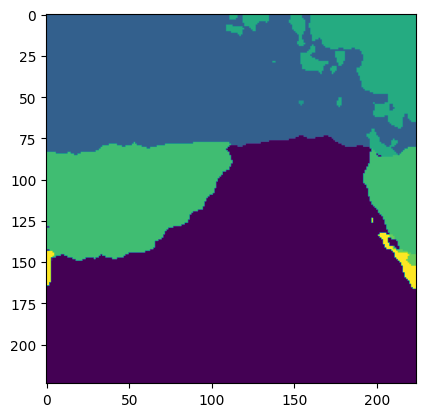

In [59]:
plt.imshow(outputs[0][0][0])

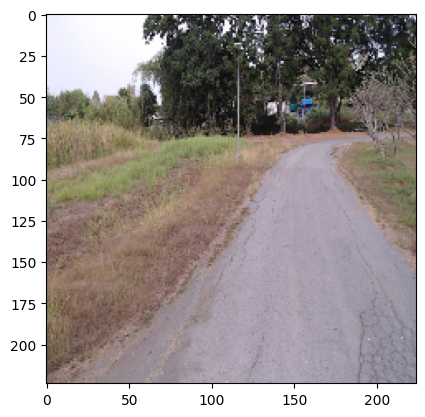

In [60]:
plt.imshow(img1)

In [55]:
upsampled_segmentation = np.resize(outputs[0], (1280, 720))

In [56]:
upsampled_segmentation

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 9, 9, 9]], dtype=int64)

In [50]:
resized_output = cv2.resize(outputs[0][0][0],(720, 1280))

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src data type = int64 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


In [29]:
import onnxruntime as ort
import numpy as np
import cv2

# Load the ONNX model
model_path = "seg/tao_model/pretrained_segformer_cityscapes_deployable_fan_tiny_hybrid_v1.0/cityscapes_fan_tiny_hybrid_224.onnx"
ort_sess = ort.InferenceSession(model_path)

# Load and preprocess your images
img1 = cv2.imread("data/raw_4cams/front/263.jpg")
img2 = cv2.imread("data/raw_4cams/left/1380.jpg")
img3 = cv2.imread("data/raw_4cams/right/1000.jpg")

# Assuming your model expects images in BGR format (OpenCV default)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# Resize images to match model input size (e.g., 224x224)
input_size = (224, 224)
img1 = cv2.resize(img1, input_size)
img2 = cv2.resize(img2, input_size)
img3 = cv2.resize(img3, input_size)

# Stack images into a batch
batch_imgs = np.stack([img1, img2, img3], axis=0)

# Prepare the input in the expected format for ONNXRuntime
input_name = ort_sess.get_inputs()[0].name  # Get the name of the input node
inputs = {input_name: batch_imgs}  # Create a dictionary mapping the input name to the input batch

# Run inference
outputs = ort_sess.run(None, inputs)

# Process the outputs as needed
print(outputs)


InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Unexpected input data type. Actual: (tensor(uint8)) , expected: (tensor(float))

# Tensorrt

In [ ]:
from optimum.onnxruntime import ORTModelForSequenceClassification
from transformers import AutoTokenizer

ort_model = ORTModelForSequenceClassification.from_pretrained(
  "philschmid/tiny-bert-sst2-distilled",
  export=True,
  provider="CUDAExecutionProvider",
)

tokenizer = AutoTokenizer.from_pretrained("philschmid/tiny-bert-sst2-distilled")
inputs = tokenizer("expectations were low, actual enjoyment was high", return_tensors="pt", padding=True)

outputs = ort_model(**inputs)
assert ort_model.providers == ["CUDAExecutionProvider", "CPUExecutionProvider"]